Reading images and labels...
Extracting features...


Processing Images: 100%|█████████████████████████████████████████████████████████████| 200/200 [00:06<00:00, 31.63it/s]


Epoch 1/10


C:\Users\hp\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.5268 - loss: 0.8363
Epoch 1: val_accuracy improved from -inf to 0.75000, saving model to best_model.keras
5/5 ━━━━━━━━━━━━━━━━━━━━ 34s 6s/step - accuracy: 0.5390 - loss: 0.8188 - val_accuracy: 0.7500 - val_loss: 0.4486 - learning_rate: 1.0000e-04
Epoch 2/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.8343 - loss: 0.4263
Epoch 2: val_accuracy improved from 0.75000 to 0.80000, saving model to best_model.keras
5/5 ━━━━━━━━━━━━━━━━━━━━ 25s 5s/step - accuracy: 0.8327 - loss: 0.4261 - val_accuracy: 0.8000 - val_loss: 0.3342 - learning_rate: 1.0000e-04
Epoch 3/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.8445 - loss: 0.3511
Epoch 3: val_accuracy improved from 0.80000 to 0.92500, saving model to best_model.keras
5/5 ━━━━━━━━━━━━━━━━━━━━ 26s 5s/step - accuracy: 0.8454 - loss: 0.3482 - val_accuracy: 0.9250 - val_loss: 0.2075 - learning_rate: 1.0000e-04
Epoch 4/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.8594 - loss: 0.3408


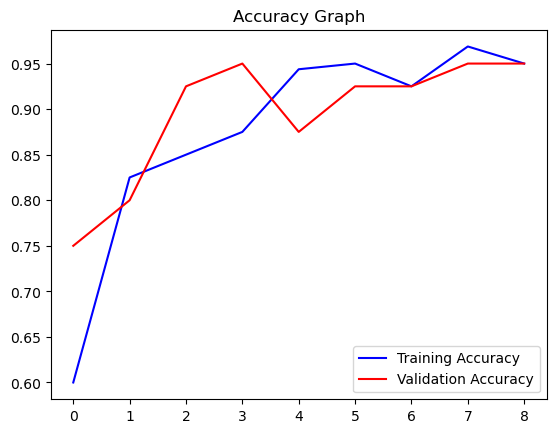

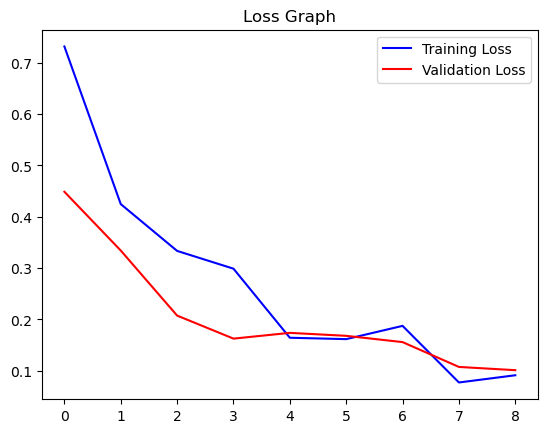

Enter the path to the test image:  cat.jpeg


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 808ms/step
Invalid Image


In [10]:
import os
import zipfile
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Dense, Dropout, Flatten, BatchNormalization, Input
from tensorflow.keras.applications import VGG16
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
import tensorflow as tf

def read_images_and_labels_from_folder(folder_path, max_images=100):
    """Read first and last N images and their labels from the folder."""
    image_paths = []
    labels = []

    all_files = []
    for root, dirs, files in os.walk(folder_path):
        for file in files:
            if file.endswith(('jpg', 'jpeg', 'png')):
                all_files.append(os.path.join(root, file))

    all_files.sort()  # Ensure consistent order

    # Select the first and last max_images
    selected_files = all_files[:max_images] + all_files[-max_images:]

    for file_path in selected_files:
        label = 0 if 'cat' in file_path.lower() else 1
        image_paths.append(file_path)
        labels.append(label)

    return image_paths, labels


def extract_features(image_paths):
    """Extract features from images"""
    features = []
    for path in tqdm(image_paths, desc="Processing Images"):
        try:
            image = Image.open(path).convert('RGB')
            image = image.resize((128, 128), Image.LANCZOS)
            img_array = np.array(image)
            if img_array.shape == (128, 128, 3):  # Ensure consistent shape
                features.append(img_array)
        except Exception as e:
            print(f"Error processing {path}: {e}")

    features = np.array(features)
    features = features / 255.0  # Normalize
    return features

def extract_zip(zip_file_path, extract_to_path):
    """Extract zip file"""
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall(extract_to_path)

def build_model():
    """Build the CNN model"""
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

    # Fine-tune the top layers of the VGG16 model
    base_model.trainable = True
    for layer in base_model.layers[:-4]:
        layer.trainable = False

    # Build the model
    inputs = Input((128, 128, 3))
    x = base_model(inputs, training=True)
    x = Flatten()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = BatchNormalization()(x)
    outputs = Dense(1, activation='sigmoid')(x)

    model = Model(inputs, outputs)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])
    return model

def main():
    zip_file_path = 'Pet Classification.zip'  # Replace with your zip file path
    extract_to_path = 'dataset'
    os.makedirs(extract_to_path, exist_ok=True)

    # Extract the zip file
    extract_zip(zip_file_path, extract_to_path)

    # Reading the images and labels from the extracted folder
    dataset_folder_path = extract_to_path
    print("Reading images and labels...")
    image_paths, labels = read_images_and_labels_from_folder(dataset_folder_path, max_images=100)


    # Extract features from the images
    print("Extracting features...")
    X = extract_features(image_paths)
    y = np.array(labels)

    # Split dataset (stratified split to maintain class balance)
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

    # Calculate class weights for imbalance in the classes
    class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
    class_weights = dict(enumerate(class_weights))

    # Data Augmentation for training
    train_datagen = ImageDataGenerator(
        rotation_range=30,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )

    val_datagen = ImageDataGenerator()

    train_generator = train_datagen.flow(X_train, y_train, batch_size=32)
    val_generator = val_datagen.flow(X_val, y_val, batch_size=32)

    # Build the model
    model = build_model()

    # Define Callbacks
    checkpoint_path = 'best_model.keras'
    checkpoint = ModelCheckpoint(
        filepath=checkpoint_path,
        monitor='val_accuracy',
        verbose=1,
        save_best_only=True,
        mode='max'
    )
    early_stopping = EarlyStopping(
        monitor='val_accuracy',
        patience=5,
        verbose=1,
        mode='max',
        restore_best_weights=True
    )
    reduce_lr = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=3,
        verbose=1,
        min_lr=1e-6
    )

    # Train the model
    history = model.fit(
        train_generator,
        epochs=10,
        validation_data=val_generator,
        class_weight=class_weights,
        callbacks=[checkpoint, early_stopping, reduce_lr],
        verbose=1
    )

    # Load the best model
    model = load_model(checkpoint_path)

    # Plot Accuracy
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    epochs = range(len(acc))

    plt.plot(epochs, acc, 'b', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
    plt.title('Accuracy Graph')
    plt.legend()
    plt.show()

    # Plot Loss
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    plt.plot(epochs, loss, 'b', label='Training Loss')
    plt.plot(epochs, val_loss, 'r', label='Validation Loss')
    plt.title('Loss Graph')
    plt.legend()
    plt.show()

    # Predict on a new image
    def predict_image(image_path):
        try:
            image = Image.open(image_path).convert('RGB')
            image = image.resize((128, 128), Image.LANCZOS)
            img_array = np.array(image) / 255.0
            if img_array.shape != (128, 128, 3):
                print("Invalid image shape!")
                return

            pred = model.predict(img_array.reshape(1, 128, 128, 3))
            if pred[0][0] < 0.4:
                print("Invalid Image")
            else:
                label_dict = {0: 'Cat', 1: 'Dog'}
                pred_label = label_dict[round(pred[0][0])]
                print("Predicted Label:", pred_label)
                plt.imshow(img_array)
                plt.axis('off')
                plt.show()
        except Exception as e:
            print("Error predicting image:", e)

    test_image_path = input("Enter the path to the test image: ")
    predict_image(test_image_path)

if __name__ == "__main__":
    main()